# Quickstart

**Acknowledgments:** This notebook adapts the content in [this NCAR tutorial](https://github.com/NCAR/GPU_workshop/blob/workshop/12_CuPyAndLegate/12_CuPyAndLegate.ipynb) to Xarray, and uses it to illustrate `cupy-xarray`

## Setup

In [4]:
import cupy as cp
import cupy_xarray  # Adds .cupy to Xarray objects
import numpy as np
import xarray as xr

## Creating Arrays

First we create arrays on the CPU and GPU

In [2]:
# NumPy data (host / cpu)
x_cpu = np.linspace(0, 2, 5)
print("On the CPU: ", x_cpu)

# CuPy data
x_gpu = cp.linspace(2, 4, 5)
print("On the GPU: ", x_gpu)

On the CPU:  [0.  0.5 1.  1.5 2. ]
On the GPU:  [2.  2.5 3.  3.5 4. ]


And now wrap those in a Xarray DataArray

In [3]:
da_gpu = xr.DataArray(x_gpu, dims="x")
da_gpu

<xarray.DataArray (x: 5)>
array([2. , 2.5, 3. , 3.5, 4. ])
Dimensions without coordinates: x

That was easy! Xarray seamlessly wraps numpy array-like objects that [support specific protocols](https://docs.xarray.dev/en/stable/internals/duck-arrays-integration.html).

For array-specific functionality Xarray recommends adding new packages that provide ["accessors"](https://docs.xarray.dev/en/stable/internals/extending-xarray.html) on Xarray objects. 

For example, the [pint-xarray](https://pint-xarray.readthedocs.io/en/latest/) package that wraps unit-aware pint arrays and provides a `.pint` for unit-specific functionality.

In this tutorial, we demonstrate `cupy-xarray` which provides a `cupy` accessor that in turn provides access to cupy-specific functionality.

## Checking for cupy arrays

Unfortunately the text representation of CuPy arrays isn't [very informative](https://github.com/cupy/cupy/issues/6926) so it isn't obvious that this DataArray wraps a CuPy array on the GPU.

In [5]:
da_gpu

<xarray.DataArray (x: 5)>
array([2. , 2.5, 3. , 3.5, 4. ])
Dimensions without coordinates: x

Instead we'll use the `is_cupy` property provided by the `cupy` accessor

In [6]:
da_gpu.cupy.is_cupy

True

## Accessing the underlying array

Use the `DataArray.data` property to access the underlying CuPy Array

In [12]:
da_gpu.data

array([2. , 2.5, 3. , 3.5, 4. ])

This means we now have access to CuPy-specific properties

In [13]:
da_gpu.data.device

<CUDA Device 0>

## Moving data between CPU and GPU (or host and device)

Xarray provides [DataArray.as_numpy](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.as_numpy.html#xarray.Dataset.as_numpy) to convert all kinds of arrays to numpy arrays

In [7]:
# Move data to host
da_cpu = da_gpu.as_numpy()
da_cpu

<xarray.DataArray (x: 5)>
array([2. , 2.5, 3. , 3.5, 4. ])
Dimensions without coordinates: x

Let's make sure this isn't a cupy array anymore

In [8]:
da_cpu.cupy.is_cupy

False

To convert a numpy array to a CuPy array (move data to GPU) use `cupy.as_cupy()`

In [9]:
# Move data to GPU
da_cpu.cupy.as_cupy()

<xarray.DataArray (x: 5)>
array([2. , 2.5, 3. , 3.5, 4. ])
Dimensions without coordinates: x

In [14]:
da_cpu.as_cupy().cupy.is_cupy

True

## Most operations are agnostic to array type


In [20]:
# works on both CPU and GPU
print("is_gpu: ", (da_gpu + 1).cupy.is_cupy)
da_gpu + 1

is_gpu:  True


<xarray.DataArray (x: 5)>
array([3. , 3.5, 4. , 4.5, 5. ])
Dimensions without coordinates: x

In [23]:
expanded = da_gpu.expand_dims(y=3)
expanded.cupy.is_cupy

True

Alignment is a fundamental Xarray operation. It preserves array types

In [26]:
aligned = xr.align(da_gpu, expanded)
[a.cupy.is_cupy for a in aligned]

[True, True]

## Data example

In [19]:
# Pull in the time series data to GPU
data_gpu = cp.loadtxt("code/gracets/data/grace_raw.o")

# Separate dates and amplitude
date_gpu = data_gpu[:, 0]
amp_gpu = data_gpu[:, 1]

grace = xr.DataArray(
    amp_gpu, 
    dims="time",
    # We can't acutally use GPU arrays as dimension coordinates or indexes yet
    coords={"time": ("time", date_gpu.get(), {"units": "years"})}, 
    attrs={"long_name": "GRACE Annual Amplitude", "units": "mm"},
)
grace

<xarray.DataArray (time: 156)>
array([  7.63,   8.93, -20.05, -41.2 , -44.21, -19.37,   4.91, -18.3 ,
        -5.03,  32.21,  31.7 ,  15.79, -23.61, -37.59, -34.69, -35.86,
       -18.97, -32.02, -22.92,   0.69,   2.27,  11.71, -22.44, -45.43,
       -41.81, -28.86, -32.42, -36.35, -16.55,  -3.77,  34.89,  56.89,
        56.33,  46.14,  69.28,  56.66,  17.73,  23.81,  -0.39,  -2.34,
        -4.87,  -5.25,   6.23,   4.54,  20.39,  30.26,  21.81,  17.42,
        -0.11,   5.18,  16.91,  14.64,   4.96,   7.06,  11.57,  13.16,
        20.17,  19.69,  10.72,  11.45, -16.18,  -5.59, -19.96, -24.43,
       -39.45,  -9.04,  11.72,  42.64,  30.67,  19.82,   9.99,   3.24,
        -7.2 , -16.17, -21.29, -30.82, -24.68, -10.06,   4.19,   8.26,
         5.91,  16.84,   8.2 ,   2.29,  -2.59, -16.31, -42.7 , -36.32,
       -49.54, -14.12,  -1.66,  35.56,  52.06,  48.79,  42.54,  32.32,
         6.74,  15.86, -21.49, -15.73, -14.11,  12.69,  34.83,  38.12,
        64.46,  36.15,  20.43,  24.13,   1.33,  -2.42,  14.68,  -8.48,
        -6.46,  -1.4 ,  13.59,   7.54, -29.34, -23.67, -30.2 , -45.15,
       -66.98, -33.63, -45.  , -41.57, -37.32, -42.41, -51.05, -63.18,
       -44.64, -54.89, -60.3 , -44.46, -38.94, -27.79, -33.55, -31.11,
       -49.71, -57.38, -68.76, -85.16, -25.79, -42.06, -52.18, -43.12,
       -41.98, -70.26, -75.15, -82.79, -55.19, -45.08, -23.77, -17.77,
       -51.03, -66.17, -46.  , -67.87])
Coordinates:
  * time     (time) float64 2.002e+03 2.002e+03 ... 2.017e+03 2.017e+03
Attributes:
    long_name:  GRACE Annual Amplitude
    units:      mm

In [20]:
grace.cupy.is_cupy

True

In [21]:
print("Min:", grace.min(), "\nMax:", grace.max(), "\nMean:", grace.mean())

Min: <xarray.DataArray ()>
array(-85.16) 
Max: <xarray.DataArray ()>
array(69.28) 
Mean: <xarray.DataArray ()>
array(-10.16467949)


But we can use `np.round` which dispatches

In [23]:
np.round(grace.mean(), 2)

<xarray.DataArray ()>
array(-10.16)

In [24]:
np.round(grace.mean(), 2).cupy.is_cupy

True

Text(0.5, 1.0, 'GRACE Time Series on GPU')

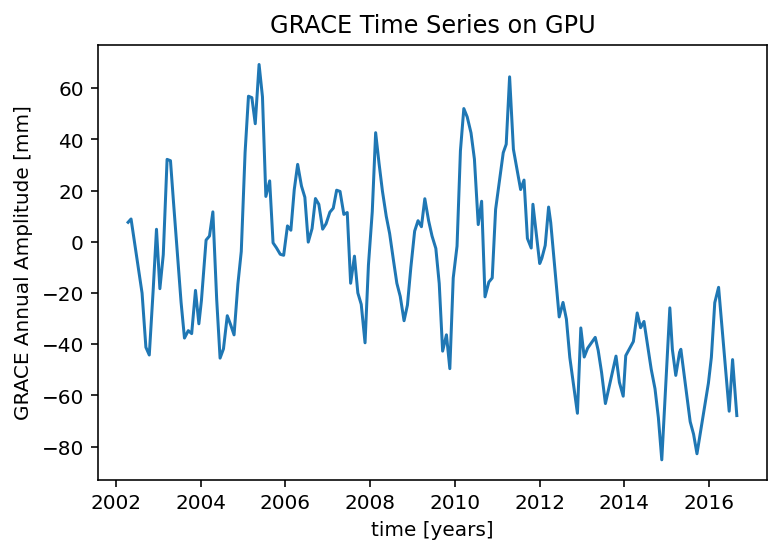

In [25]:
# seamlessly converts to CPU array for plotting
grace.plot()
plt.title("GRACE Time Series on GPU")

##  Custom kernels with apply_ufunc

Custom kernels in CuPy use C language syntax to write compiled code within Python.

In [16]:
x = cp.arange(6, dtype='f').reshape(2, 3)
y = cp.arange(3, dtype='f')

kernel = cp.ElementwiseKernel(
    'float32 x, float32 y', 'float32 z',
    '''
    if (x - 2 > y) {
      z = x * y;
    } else {
      z = x + y;
    }
    ''', 'my_kernel')

kernel(x, y)

array([[ 0.,  2.,  4.],
       [ 0.,  4., 10.]], dtype=float32)

We can apply these and other custom kernels using `xarray.apply_ufunc`

In [17]:
xda = xr.DataArray(x, dims=("a", "b"))
yda = xr.DataArray(y, dims=("b"))
result = xr.apply_ufunc(
    kernel,
    xda,
    yda,
)
print("is_gpu:", result.cupy.is_cupy)
result

is_gpu: True


<xarray.DataArray (a: 2, b: 3)>
array([[ 0.,  2.,  4.],
       [ 0.,  4., 10.]], dtype=float32)
Dimensions without coordinates: a, b